# IMPORTS, FUNCTIONS AND OTHER STATIC STUFF

In [47]:
### IMPORTS ###
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch.nn as nn
import numpy as np
import os, json
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F
from skimage.segmentation import mark_boundaries
from lime import lime_image
from pathlib import Path

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
CAT_IMG_PATH = ROOT_DIR / 'predict' / 'cat'
DOG_IMG_PATH = ROOT_DIR / 'predict' / 'dog'
CAT_AND_DOG_IMG_PATH = ROOT_DIR / 'cat_and_dog_in_same_image'
BLACKBOX_CLASSIFIER_WEIGHT_PATH = ROOT_DIR / 'blackboxclassifier_weights' / 'CatVsDog_weights'
classes = ["Cat", "Dog"]

### FUNCTIONS ###
def get_image(path):
    #randomly pick a dog or cat image from image folder
    img_files = list(path.glob('*.jpg*'))
    img_file = random.choice(img_files)
    img_path_file = path / img_file
    with open(os.path.abspath(img_path_file), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

        
def imshow(img):
    """
    Used to show images with blackbox classifier
    """
    inv_normalize = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
    img = inv_normalize(img)
    img = torch.squeeze(img)
    npimg = 255 * img.numpy()
    npimg = npimg.astype('uint8')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()        

def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()


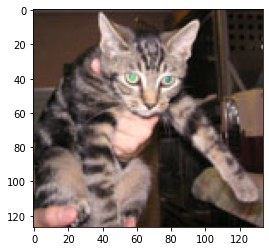

In [48]:
#display a cat image
img = get_image(CAT_IMG_PATH)
plt.imshow(img)

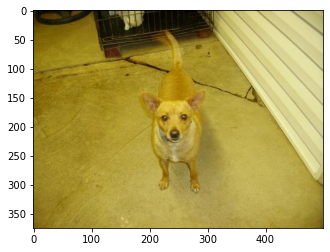

In [49]:
#display a dog image
img = get_image(DOG_IMG_PATH)
plt.imshow(img)

# BLACK BOX CLASSIFIER

Prediction: Cat


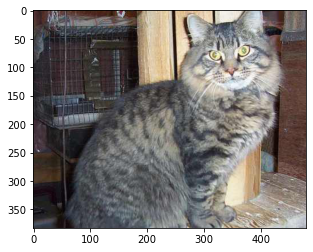

In [72]:
#same architecture used as https://github.com/amitrajitbose/cat-v-dog-classifier-pytorch
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.1),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

#load model weights from black box training (Train loss: 0.109.. Test loss: 0.031.. Test accuracy: 0.988)
model.load_state_dict(torch.load(BLACKBOX_CLASSIFIER_WEIGHT_PATH))
model.eval()

#test prediction
img = get_image(CAT_IMG_PATH)
pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()
out = model(torch.unsqueeze(preprocess_transform(np.array(pill_transf(img))), dim=0))
class_idx = torch.max(F.softmax(out, dim=1), dim=1).indices
plt.imshow(img)
print(f"Prediction: {classes[class_idx]}")

# LIME

In [76]:
### LIME ###
#LIME code taken and modified from https://github.com/marcotcr/lime
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=2, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

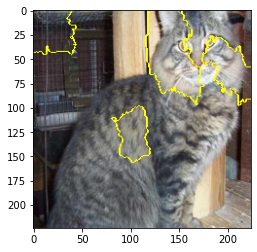

In [77]:
#Visualizing explained features 
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

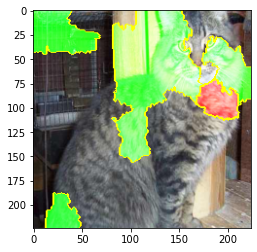

In [78]:
#Visualizing explained features with coloring (green= areas contributing for top prediction red=areas contributing against top prediction)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)